# Weapon Damage by Target

## Setting Up

In [1]:
import pandas as pd
from weapon import max_shots, burst
from accuracy import average_to_hit

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

We will use an average Accuracy of 50. Meaning the soldier fails half of the time.

The chance of hit formula is simple. Just multiply the soldier's accuracy chance by the weapon's accuracy chance. So an average of 50 to a weapon of Accuracy 90 means 0.50 * 0.9 = 0.45 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: average_to_hit(x["accuracy"]), axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,turn_max_shots
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,1
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,1
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,1
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,1
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,6


## Damage to Target Type

### Data Merge

In [5]:
weapon_damages = weapon_attacks
weapon_damages = weapon_damages.append([weapon_damages] * (len(damage_modifiers.index)-1), ignore_index=True)
weapon_damages["key"] = weapon_damages.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

targets = damage_modifiers["target"]

weapon_damages = pd.merge(weapon_damages, targets, left_on="key", right_index=True, how="left", sort=False)
weapon_damages = weapon_damages.drop(columns=["key"])
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,turn_max_shots,target
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,1,terrain
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,1,terrain
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,1,terrain
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,1,terrain
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,6,terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,1,1,zombie
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,1,2,zombie
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,1,1,zombie
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,1,2,zombie


### Damage vs Type

In [6]:
def damage_modifier(group):
    """
    Returns the damage modifier for the weapon target.
    """
    target = damage_modifiers[damage_modifiers["target"] == group["target"]]
    damage = target[group["damage_type"]].values[0]
    return damage / 100

In [7]:
weapon_damages["target_damage"] = weapon_damages.apply(lambda x: x["damage"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_max"] = weapon_damages.apply(lambda x: x["turn_max_shots"] * x["target_damage"], axis=1)
weapon_damages["target_turn_damage_expected"] = weapon_damages.apply(lambda x: x["target_turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,turn_max_shots,target,target_damage,target_turn_damage_max,target_turn_damage_expected
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,1,terrain,90.0,90.0,32.175
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,1,terrain,42.0,42.0,18.942
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,1,terrain,44.0,44.0,19.844
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,1,terrain,48.0,48.0,21.648
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,6,terrain,42.0,252.0,44.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,1,1,zombie,68.0,68.0,43.010
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,1,2,zombie,68.0,136.0,41.140
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,1,1,zombie,0.0,0.0,0.000
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,1,2,zombie,0.0,0.0,0.000


## Weapon Damages by Target

In [8]:
weapon_damages_targets = weapon_damages.groupby(["weapon", "target"]).mean()
weapon_damages_targets = weapon_damages_targets[["target_turn_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"target_turn_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])
weapon_damages_targets

turn_damage
weapon           target                
stun_rod         zombie        0.000000
small_launcher   zombie        0.000000
grenade          cyberdisk    10.725000
                 tank         13.406250
                 sectopod     14.300000
...                                 ...
heavy_plasma     ethereal    133.879167
                 cyberdisk   133.879167
                 muton       133.879167
heavy_laser      sectopod    165.825000
blaster_launcher silacoid    171.600000

[322 rows x 1 columns]

### Kinetic Weapons

Text(0, 0.5, 'Damage')

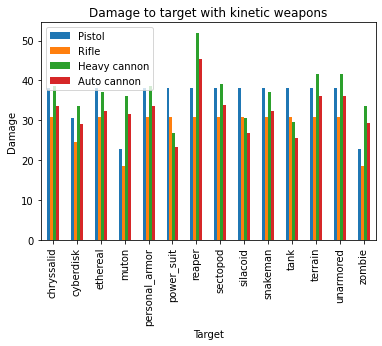

In [9]:
weapon_damages_targets_kinetic = weapon_damages_targets.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.swaplevel().unstack()
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.sort_values(by=["target"])
ax = weapon_damages_targets_kinetic.plot.bar(title="Damage to target with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Melee

Text(0, 0.5, 'Damage')

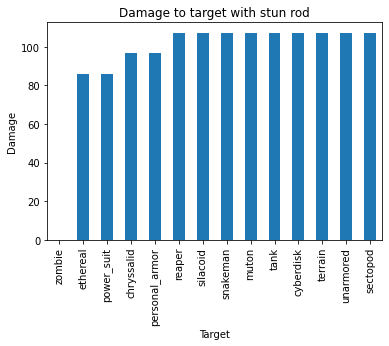

In [10]:
ax = weapon_damages_targets.loc[ "stun_rod" , : ].plot.bar(title="Damage to target with stun rod", legend=False)
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Explosive

Text(0, 0.5, 'Damage')

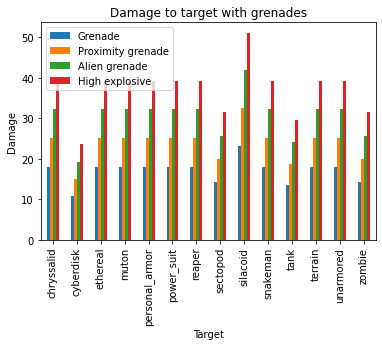

In [11]:
weapon_damages_targets_grenade = weapon_damages_targets.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_damages_targets_grenade = weapon_damages_targets_grenade.swaplevel().unstack()
weapon_damages_targets_grenade = weapon_damages_targets_grenade.sort_values(by=["target"])
ax = weapon_damages_targets_grenade.plot.bar(title="Damage to target with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

Text(0, 0.5, 'Damage')

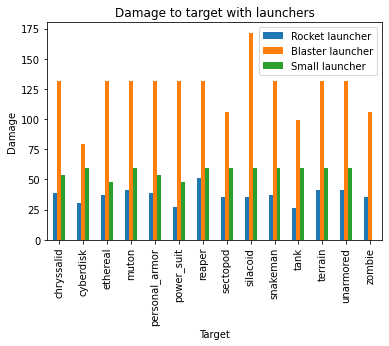

In [12]:
weapon_damages_targets_launcher = weapon_damages_targets.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_damages_targets_launcher = weapon_damages_targets_launcher.swaplevel().unstack()
weapon_damages_targets_launcher = weapon_damages_targets_launcher.sort_values(by=["target"])
ax = weapon_damages_targets_launcher.plot.bar(title="Damage to target with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Laser

Text(0, 0.5, 'Damage')

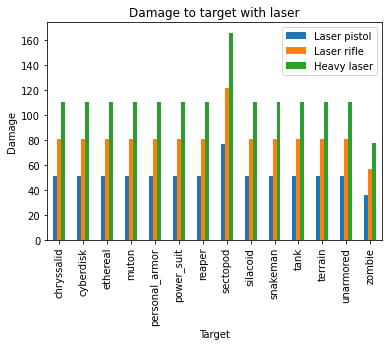

In [13]:
weapon_damages_targets_laser = weapon_damages_targets.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_damages_targets_laser = weapon_damages_targets_laser.swaplevel().unstack()
weapon_damages_targets_laser = weapon_damages_targets_laser.sort_values(by=["target"])
ax = weapon_damages_targets_laser.plot.bar(title="Damage to target with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Plasma

Text(0, 0.5, 'Damage')

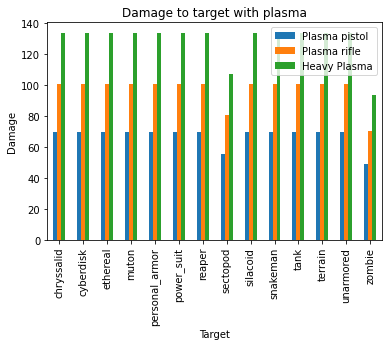

In [14]:
weapon_damages_targets_plasma = weapon_damages_targets.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_damages_targets_plasma = weapon_damages_targets_plasma.swaplevel().unstack()
weapon_damages_targets_plasma = weapon_damages_targets_plasma.sort_values(by=["target"])
ax = weapon_damages_targets_plasma.plot.bar(title="Damage to target with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Tank

Text(0, 0.5, 'Damage')

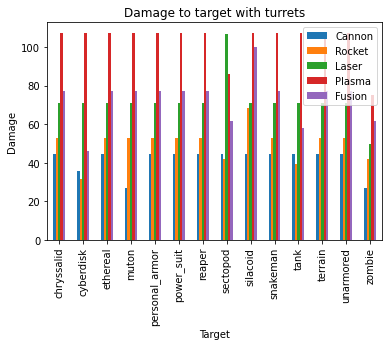

In [15]:
weapon_damages_targets_tank = weapon_damages_targets.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_damages_targets_tank = weapon_damages_targets_tank.swaplevel().unstack()
weapon_damages_targets_tank = weapon_damages_targets_tank.sort_values(by=["target"])
ax = weapon_damages_targets_tank.plot.bar(title="Damage to target with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Target Damage Lists

#### Averages

In [16]:
weapon_damages_average = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_average = weapon_damages_average.sort_values(by=["turn_damage"])

In [17]:
weapon_damages_max = weapon_damages_targets.groupby(["weapon"]).max()
weapon_damages_max = weapon_damages_max.sort_values(by=["turn_damage"])

In [18]:
average_damages_expected = weapon_damages_max.merge(weapon_damages_average, on="weapon")
average_damages_expected = average_damages_expected.rename(columns={"turn_damage_x": "max", "turn_damage_y": "average"})
average_damages_expected = average_damages_expected.sort_values(by=["average"])
average_damages_expected

,max,average
weapon,,
grenade,23.237500,16.917411
proximity_grenade,32.532500,23.684375
rifle,30.800000,28.600000
alien_grenade,41.827500,30.451339
auto_cannon,45.270622,32.062189
pistol,38.181000,35.453786
heavy_cannon,51.975000,36.824464
rocket_launcher,51.113333,36.929717
high_explosive,51.122500,37.218304


Text(0, 0.5, 'Damage')

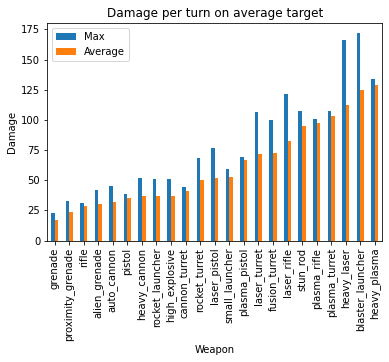

In [19]:
ax = average_damages_expected.plot.bar(title="Damage per turn on average target", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Terrain

In [20]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

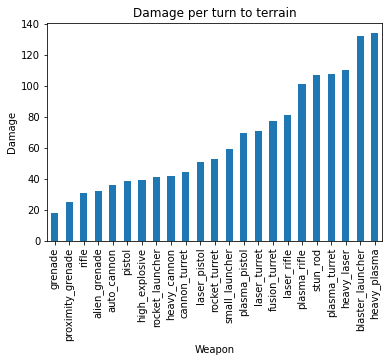

In [21]:
ax = weapon_damages_terrain.plot.bar(title="Damage per turn to terrain", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Unarmored

In [22]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

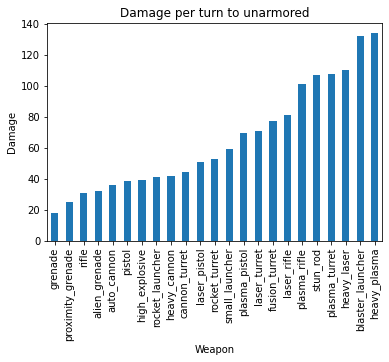

In [23]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to unarmored", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Personal Armor

In [24]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

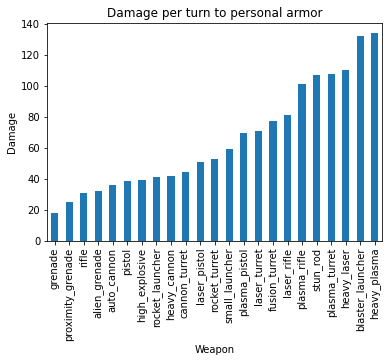

In [25]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to personal armor", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Power Suit

In [26]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

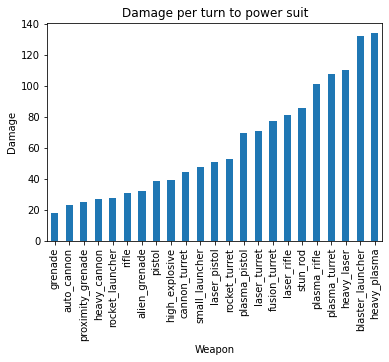

In [27]:
ax = weapon_damages_power_suit.plot.bar(title="Damage per turn to power suit", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Tank

In [28]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

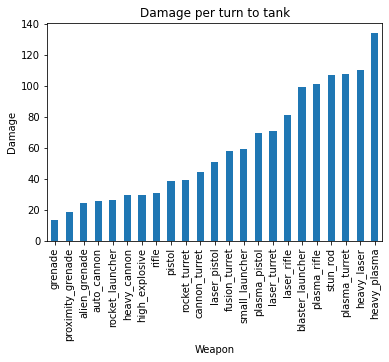

In [29]:
ax = weapon_damages_tank.plot.bar(title="Damage per turn to tank", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Snakeman

In [30]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

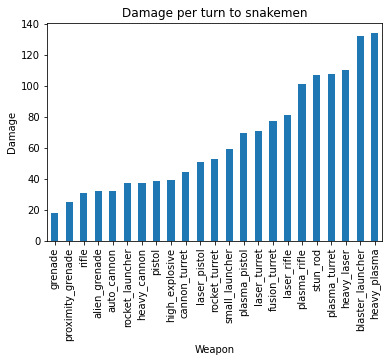

In [31]:
ax = weapon_damages_snakeman.plot.bar(title="Damage per turn to snakemen", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Ethereal

In [32]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

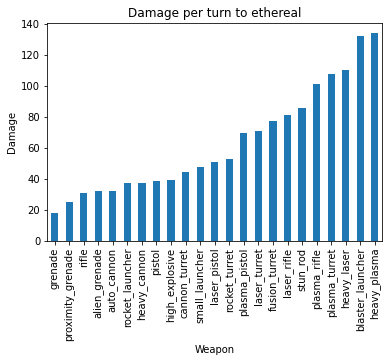

In [33]:
ax = weapon_damages_ethereal.plot.bar(title="Damage per turn to ethereal", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Muton

In [34]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

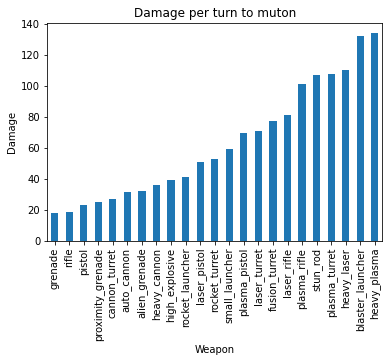

In [35]:
ax = weapon_damages_muton.plot.bar(title="Damage per turn to muton", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Silacoid

In [36]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

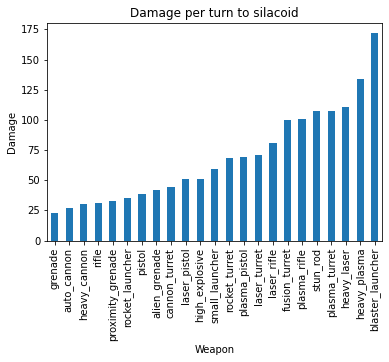

In [37]:
ax = weapon_damages_silacoid.plot.bar(title="Damage per turn to silacoid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Chryssalid

In [38]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

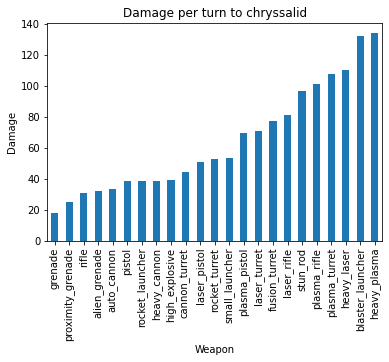

In [39]:
ax = weapon_damages_chryssalid.plot.bar(title="Damage per turn to chryssalid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Reaper

In [40]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

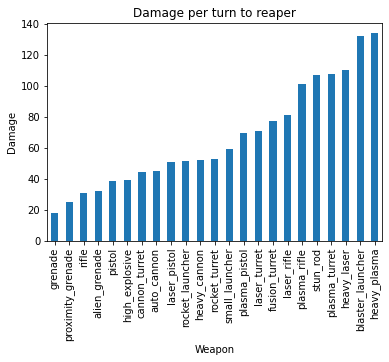

In [41]:
ax = weapon_damages_reaper.plot.bar(title="Damage per turn to reaper", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Sectopod

In [42]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

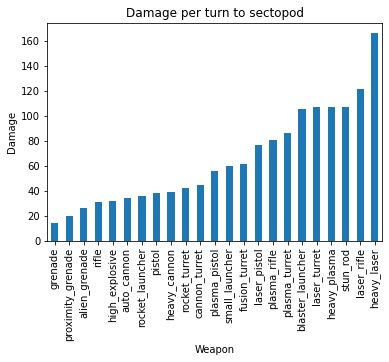

In [43]:
ax = weapon_damages_sectopod.plot.bar(title="Damage per turn to sectopod", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Cyberdisk

In [44]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

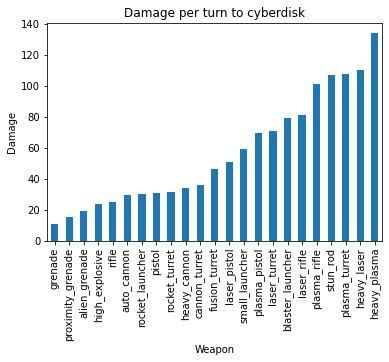

In [45]:
ax = weapon_damages_cyberdisk.plot.bar(title="Damage per turn to cyberdisk", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Zombie

In [46]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

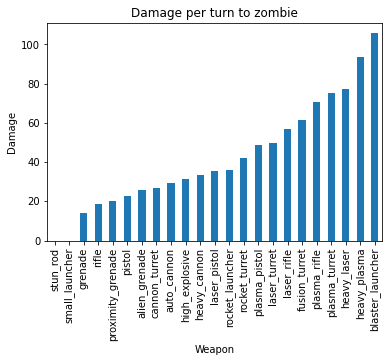

In [47]:
ax = weapon_damages_zombie.plot.bar(title="Damage per turn to zombie", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")